# **Lab 5. Tracking**

## Objectives

* Gain a practical understanding of single and multiple-object tracking in videos.

## Overview

This lab is divided in two main parts and will be done in two sessions. In the first part you will build a Mean-Shift Tracker. In the second part, you will build multiple object tracker. Please remember, this lab's grade will be **double the points** of one previous lab.

## How shall I do it?
* Track the object in online (i.e. just taking into account seen frames and not the whole video).
* Program your own tracker.
    * You **cannot** use external code unless specified.
    * You are not allowed to use tracking libraries/modules.
    * If you would like to use an external module ask the instructor.        

## Deliverable

**Deadline**: <font color='red'> 06/03/25 at 23:59h </font>

**Submission**:

* The completed Jupyter Notebook with the following characteristics:
    * All cells must have been executed and work, i.e. they should run.
    * Clear commented code cells when necessary.
    * Clean notebook:
        * The running order is top-down.
        * Non-necessary cells must be removed.
    * Reproducible results:
        * The code must produce the same results when run by others.
* Address all tasks marked as <font color='green'>**TX.**</font>
* Remember you do not need to upload a report for this lab, however, you **still must** justify your parameters, answers and make proper analyses wherever asked.
* Submit a single zip file per group in the corresponding delivery task in Aula Global. The submitted zip file has to contain your report and your source code (and all files needed to run it, such as images, other dependencies, etc). The lab will be done in groups of two persons.
* For practicality, we suggest you to use Google Colab.

## Colab Setup

After uploading and unzipping the files in your **Google Drive**, mount them  in **Colab**:

In [88]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Then, find the path to your lab directory and set it up as follows:

In [89]:
# LAB5_DIRPATH = '/content/drive/MyDrive/PATH/TO/LAB5/DIRECTORY'
LAB5_DIRPATH = '/content/drive/MyDrive/3r/2n_trimestre/Video_processing/LAB05/provided_files'

Change the execution path to your lab directory path. This is crucial to import external scripts automatically.

In [90]:
import os

os.chdir(LAB5_DIRPATH)

Run the following command to install the needed video packages and its dependencies

In [91]:
# !apt install ffmpeg # May not work if you are running on local Windows OS.

# !pip install scikit-video

## **Part I. Single Object Tracking**

In this part, you will develope a Mean-shift tracker.

### 1. Tracking Mario


The task consists of tracking *Mario Bros* in the following video when he is lowering a flag from a green pole. Our inputs are Mario’s video at <span style="color:red"><tt>'videos/mario.mp4'</tt></span> and its initial target, a bounding ellipse centered at ``(640, 150)`` and axes lengths ``(35, 50)``.

**Visualizing the video**. Let's display the video using Jupyter's API. *Note that this only displays the video in the notebook.*


In [92]:
from utils import display_video

display_video('videos/mario.mp4', width=480, height=360)

**Loading the video**. In this lab, we will use Scikit-Video and Scikit-Image along with OpenCV to perform loading and processing operations.

In [93]:
from utils import read_video
from skimage import io

frames = read_video('videos/mario.mp4')
num_frames = len(frames)

**Displaying the initial target**. Once we load the RGB frames, we can display the initial target having an ellipse centered at ``(640, 150)`` and axes lengths ``(35, 50)`` in the first frame and the patch it contains. In the cell below , the ``target`` is drawn in cyan using the function ``draw_ellipsis`` from the ``tracking`` module.

*NOTE: The provided ``tracking`` module contains the data structures for bounding boxes, detections, and their visualization functions. You should look carefully at them and use them for your trackers.*

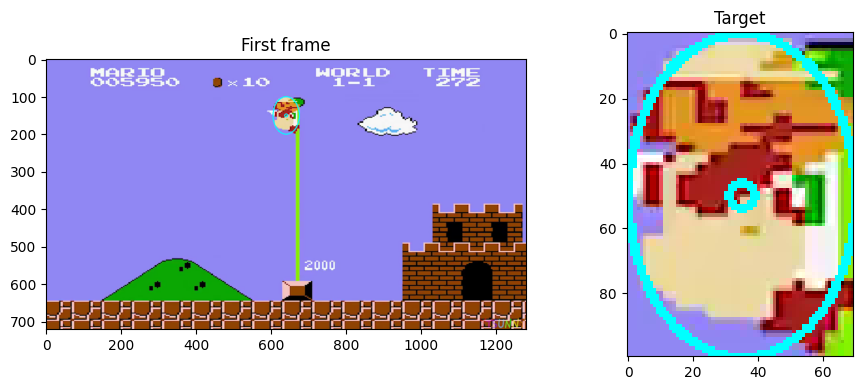

In [94]:
import matplotlib.pyplot as plt


from tracking import BoundingEllipse
from tracking import draw_ellipses
import numpy as np


target = BoundingEllipse(center=(640, 150),
                         axes_lengths=(35, 50))

patch = frames[0][target.y1:target.y2,
                  target.x1:target.x2, :]

drawn_frame = draw_ellipses(frames[0], target, color=(0,255,255))
drawn_target = drawn_frame[target.y1:target.y2, target.x1:target.x2, :]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.set_title("First frame")
ax1.imshow(drawn_frame)
ax2.set_title("Target")
ax2.imshow(drawn_target)
fig.tight_layout()
plt.show()

### 2. Weighted Histogram

In this part of the lab, we will develop the weighted histogram used by the Mean-Shift tracker. Specifically, the region of the object to track contains the pixels $\mathbf{x}_{i}$ for $i=1,\ldots, n$ centered at $\textbf{0}$. This region is modeled as an $m$-dimensional color histogram $\mathbf{r}$ of the pixels $\{\mathbf{x}_{i}\}_{i=1,\ldots, n}$ weighted by a kernel profile $k$, thus diminishing the contribution of pixels that are distant from the center. Explicitly, the probability of the feature $u=1, \ldots, m$ in the object model is defined as

$$r_{u}=C\sum_{i=1}^{n}k\big(\big\lVert \mathbf{x}_{i} \big\rVert^{2}\big)\delta\big(b(\mathbf{x}_{i})-u\big)$$

where $C$ represents the normalization constant that guarantees that $\sum_{u=1}^{m}r_{u}=1$, this is

$$C=\bigg[\sum_{i=1}^{n}k\big(\big\lVert \mathbf{x}_{i} \big\rVert^{2}\big)\bigg]^{-1}$$

and $\delta$ corresponds to the Kronecker delta function:

$$\delta(a) = %
\begin{cases}
  1 & \mbox{if $a = 0$}\\
  0 & \mbox{otherwise}
\end{cases}
$$

<font color='green'>**T1. Pixel coordinates of the bounding ellipse**. Using the ``ellipse`` function defined in ``skimage.draw``, complete the function ``get_coordinates`` that obtains the coordinates of all pixels inside the ellipse defined by the class ``BoundingEllipse``. State the number of pixels inside ellipse defined by the variable ``target``.

**This function extracts the pixels coordinates of the file that lie inside a given elliptical region within an image , the image where the frame is drawn_frame. Retrieves  from target of the file , the center (row, col) and axes lengths (radius_row, radius_col) from BoundingEllipse.Uses skimage.draw.ellipse() to compute all pixel locations inside the ellipse.Ensures all computed pixel positions stay within valid image dimensions.
Finally outputs, the function returns an array of (col, row) pixel positions inside the ellipse.**

In [95]:
from skimage.draw import ellipse

def get_coordinates(ellipse_bbox, img):

    # Extract parameters of the ellipse of bounding box
    center_row = ellipse_bbox.center[1]
    center_col = ellipse_bbox.center[0]
    axs_row = ellipse_bbox.axes_lengths[1]
    axs_col = ellipse_bbox.axes_lengths[0]

    #Generate the coordenates of the ellipse using the function of skimage.draw
    rows, cols = ellipse(center_row, center_col, axs_row, axs_col, shape=img.shape)

    return np.vstack((cols, rows)).T

<font color='green'>**T2. Normalized pixel coordinates of the bounding ellipse**. In this task we will obtain the normalized coordinates of the pixels $\mathbf{x}_{i}$ for $i=1,\ldots, n$ within the ellipse. Create a function named ``normalize_coords`` that given a ``BoundingEllipse`` object and an array of coordinates computes their normalized position with respect to the center of the ellipse, as well as its height and width.

<font color='green'> **NOTE: The absolute value of ``norm_coords-target.center`` should be <= 1.**

**Once we've obtained the coordinates of the mario file we'll normalize it with the function created, again we'll use the target (BoundingEllipse) to extract the information of the frame. For the normalization we'll use the result of get_coordinates of the column and row , and normalize it.**

In [96]:
def normalize_coords(ellipse_bbox, coords):

    center_row = ellipse_bbox.center[1]
    center_col = ellipse_bbox.center[0]
    radius_row = ellipse_bbox.axes_lengths[1]
    radius_col = ellipse_bbox.axes_lengths[0]

    # obtain normalized coordenates
    norm_cols = (coords[:, 0] - center_col) / radius_col #extract the column values
    norm_rows = (coords[:, 1] - center_row) / radius_row #extract the rows values

    return np.vstack((norm_cols, norm_rows)).T

In [97]:
mario_coordinates= get_coordinates(target,drawn_frame)
mario_normalized = normalize_coords(target, mario_coordinates)

<font color='green'>**T3. Epanechnikov kernel**.
    
<font color='green'>&#9679;&ensp; Create a function named ``epanechnikov_profile`` that given an array of coordinates computes the profile of the Epanechnikov kernel defined by:

$$k(x) = \begin{cases}
  c(1-x) & \mbox{if $0 \leq x \leq 1$}\\
  0 & \mbox{otherwise}
\end{cases}$$

<font color='green'> where $c=\dfrac{2}{\pi}$.

<font color='green'>&#9679;&ensp; Using the previous function, create a function named ``epanechnikov`` that given an array of coordinates computes the 2-D parabolic kernel defined by:

$$K(\mathbf{x}) = \begin{cases}
  c(1-\lVert \mathbf{x}\rVert^{2}) & \mbox{if $\lVert  \mathbf{x} \rVert^{2} \leq 1$}\\
  0 & \mbox{otherwise}
\end{cases}$$

<font color='green'> where $c=\dfrac{2}{\pi}$.

<font color='green'> **HINT:** For good practice, you can reduce kernel profile computation to _one-line code_ by operating on matrix.

**For computing epanechnikov profile que follow the conditios stated above, where only the elements selected from the array of coordinates selects the ones contained in 0≤𝑥≤1 , otherwise 0 .**

**For computing the epanechnikov we can use the function epanechnikov profile**

In [98]:
from numpy import linalg as LA


def epanechnikov_profile(x):
    c = 2 / np.pi
    profile = np.where(( x>= 0) & (x <= 1), c * (1 - x), 0) #for every value of the array that follows this condition ...
    return profile

def epanechnikov(x):
    #c = 2 / np.pi
    square = np.sum(x**2,axis = -1)

    return epanechnikov_profile(square)


K = epanechnikov(mario_normalized) #use the normalize values obtained before

The function ``calculate_color_bins`` computes the corresponding histogram bin index of each pixel inside an RGB image ``img`` given the locations ``coords``. The bins correspond to a histogram that equally divides each dimension of the RGB colorspace by ``num_bins_per_color_channel``.

In [99]:
def calculate_color_bins(img, coords, num_bins_per_color_channel):
    cols, rows = coords[:, 0], coords[:, 1]
    quantized_region = (img[rows, cols, :] // (256 // num_bins_per_color_channel)).astype(np.uint8)
    return np.ravel_multi_index(quantized_region.T, (num_bins_per_color_channel, num_bins_per_color_channel, num_bins_per_color_channel), mode='clip')

num_bins_per_color_channel = 5

bins = calculate_color_bins(frames[0], mario_coordinates, num_bins_per_color_channel)

<font color='green'>**T4.** Determine the length $M$ of the histogram with respect to the variable ``num_bins_per_color_channel`` and store it in a variable named ``M``.

**Since there are 3 channels and 5 bins for each color , the total lenght 5^3=125.**

In [100]:
######################### COMPLETE ##########################
M = num_bins_per_color_channel ** 3 # since there are 3 channels and 5 bins for each color , the total lenght 5^3
print(M)
#############################################################

125


<font color='green'>**T5. Weighted Histogram**
    
<font color='green'>&#9679;&ensp; Create a function named ``calculate_weighted_histogram`` that computes the color histogram $\mathbf{r}$. This function takes as parameters the weighted values of the Epanechnikov kernel $k(\mathbf{x}_{i}$) for $i=1,\ldots, n$, the bins values $b(\mathbf{x}_{i}$) for $i=1,\ldots, n$, and the length dimension $m$.

<font color='green'>&#9679;&ensp; Calculate the weighted color histogram of the ``target`` and store it in a variable named ``q``.

Parameters:

- k_values: (N,) array, the kernel weights for each pixel.
- bin_values: (N,) array, the bin indices corresponding to each pixel's color.
- m: int, the lenght of the histogram.

Returns:
- histogram:  array, the normalized weighted histogram.

**Since the kernel values have already been computed above, the process is simplified. We only need to extract them and assign them to their corresponding bins, constructing the histogram adaptively.**

In [101]:
# ######################### COMPLETE ##########################

def calculate_weighted_histogram(k_values, bin_values, m):

    histogram = np.zeros(m)

    # Compute weighted sum for each bin
    for i in range(len(bin_values)):
        bin_index = int(bin_values[i])  # each pixel to a specific histogram
        weight = k_values[i]  # Kernel weight of the squared norm

        if 0<= bin_index <= m:  # kronecker delta. we only add the weight if the pixel assigned to bin i is the i-th bin
            histogram[bin_index] += weight  # Add weight to the corresponding bin

    # Compute normalization factor C
    C = 1.0 / np.sum(histogram)
    #print("Cte:", C)


    # Normalize by factor
    histogram *= C


    return histogram

# #############################################################


In [102]:
q=calculate_weighted_histogram(K,bins,M)

**The sum of the histogram's values should be one, as it is a normalized pdf**

In [103]:
print("Sum of q:",sum(q))

Sum of q: 1.0


### 2. Mean-Shift Tracking

In this part of the lab, we will first implement the Mean-Shift tracker algorithm between two frames, and then we will extend to all frames in the video.

<font color='green'>**T6. Mean-Shift Tracker**.
    
<font color='green'>&#9679;&ensp; Implement the mean-shift tracking algorithm by completing the ``mean_shift_track`` function. Note that variable ``h`` refers to the bandwidth for calculating the weighted histogram of the candidate, and the variable ``epsilon`` refers to the margin of error.

<font color='green'>&#9679;&ensp; Since the difference between two consecutive frames is too small, use your function on the eighth frame (i.e. the frame with index 7) and plot your results.

**We follow the slide's from theory to compute the mean_shift_track algorithm. Steps:**

**1:Initialize location y0. Already implemented**
**2:Compute q and p(y0) using the calculate_weighted_histogram function**
**3:Derive weights**
**4:Compute the new candidate location and shift the current position**
**5:update the current position with the new target's position**

**All of these steps are done while the convergence criteria is not met. Once is met, it stops. This ensures that the algorithm converges**

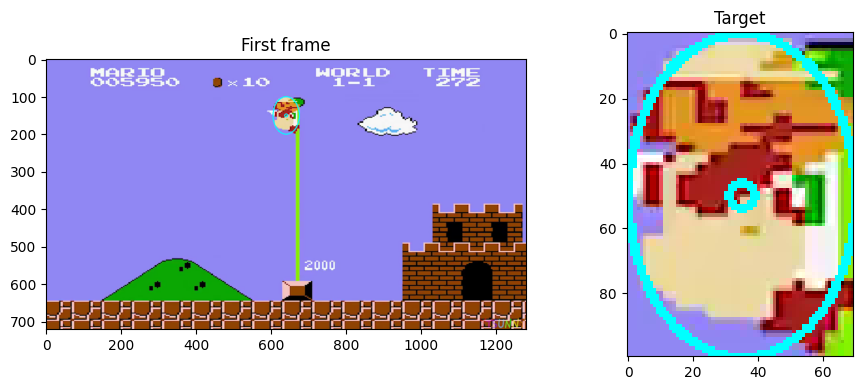

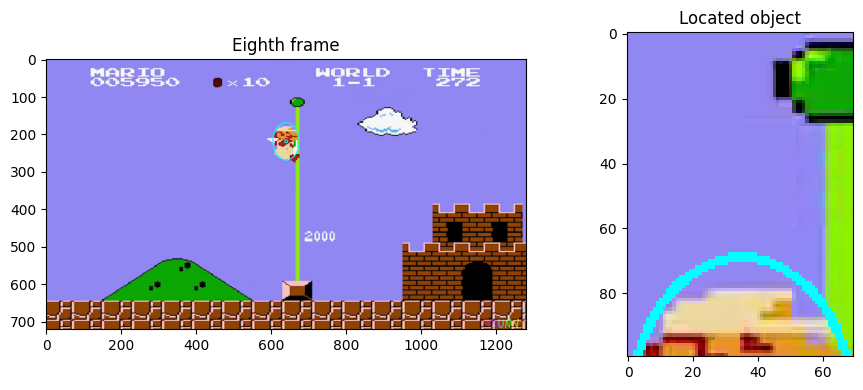

In [104]:
import copy

def mean_shift_track(current_frame, y0, q, num_bins_per_color_channel, h=1, epsilon=0.6):
    candidate = copy.deepcopy(y0)

    v = np.inf #initialize the difference between the candidate center and ynew


    while np.linalg.norm(v) > epsilon:
        coord = get_coordinates(candidate,current_frame)
        ncoord = normalize_coords(candidate,coord)

        kernel = epanechnikov(ncoord/h)
        bins = calculate_color_bins(current_frame, coord, num_bins_per_color_channel) #computes the corresponding histogram bin index of each pixel inside an RGB image

        #Compute p
        pm = calculate_weighted_histogram(kernel,bins,num_bins_per_color_channel**3)

       #compute weights
        w  = np.sqrt(q[bins] / (pm[bins])) #+ 1e-5)) #to avoid division by 0, we add a negligible value

        #shift to new candidate position
        den = np.sum(w)
        num = np.sum(w[:,None]*coord, axis = 0)
        ynew = (num/den)
        v = ynew - np.array(candidate.center)

        #update
        candidate.center = np.array(candidate.center) + v

    return candidate


drawn_frame = draw_ellipses(frames[0], target, color=(0,255,255))
drawn_target = drawn_frame[target.y1:target.y2,
                           target.x1:target.x2, :]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.set_title("First frame")
ax1.imshow(drawn_frame)
ax2.set_title("Target")
ax2.imshow(drawn_target)
fig.tight_layout()
plt.show()


located_object = mean_shift_track(frames[7], target, q, num_bins_per_color_channel, h=1, epsilon=0.6)

drawn_frame = draw_ellipses(frames[7], located_object, color=(0,255,255))
drawn_target = drawn_frame[located_object.y1:located_object.y2,
                           located_object.x1:located_object.x2, :]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.set_title("Eighth frame")
ax1.imshow(drawn_frame)
ax2.set_title("Located object")
ax2.imshow(drawn_target)
fig.tight_layout()
plt.show()

<font color='green'>**T7. Mean shift tracker for videos**. The following code forms the skeleton of a full Mean-Shift tracker. Use the ``mean_shift_track`` function **without modifying it** to complete the ``track_single_object`` function.  After visualizing the track, evaluate your results. </font>

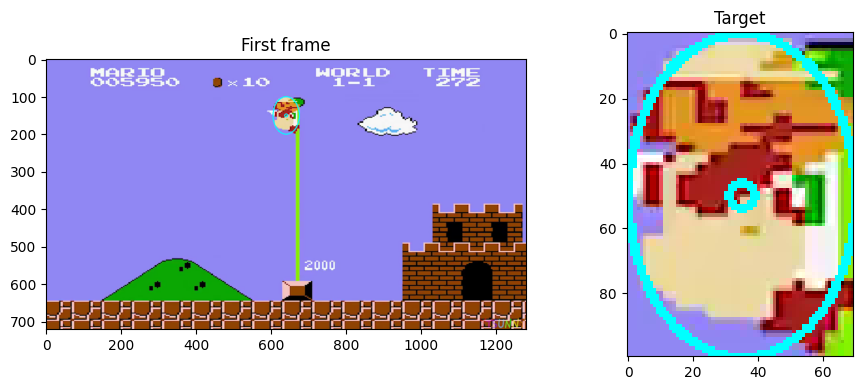

In [105]:
from tracking import DetectionBox


def track_single_object(frames, target, num_bins, h=1, epsilon=0.6):

    # Initializing the detections data structure
    detections = {frame_idx: [] for frame_idx in range(num_frames)}

    # Setting the first detection
    detections[0].append(target)


    #Drawing the first ellipse
    drawn_frame = draw_ellipses(frames[0], detections[0][0], color=(0,255,255)) #there's a list inside every element. That is why you need to call [0][0] (list 0 of element 0)
    drawn_target = drawn_frame[detections[0][0].y1:detections[0][0].y2,
                                detections[0][0].x1:detections[0][0].x2, :]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.set_title("First frame")
    ax1.imshow(drawn_frame)
    ax2.set_title("Target")
    ax2.imshow(drawn_target)
    fig.tight_layout()
    plt.show()

    #Initialize the coordinates and variables for the first frame
    icords = get_coordinates(target, frames[0])
    incords = normalize_coords(target, icords)
    ikernel = epanechnikov(incords)
    ibins = calculate_color_bins(frames[0], icords, num_bins) #we need to reshape q
    iq = calculate_weighted_histogram(ikernel,ibins,num_bins**3)

    previous_detection = target


    ######################### COMPLETE ##########################
    for i in range(1, len(frames)):

        # we use the mean shift algorithm to find the new target position
        newtarget = mean_shift_track(frames[i], previous_detection, iq, num_bins, h, epsilon)

        # we update the center and axes lengths of the BoundingEllipse using newtarget
        new_detection = BoundingEllipse(center=newtarget.center, axes_lengths=newtarget.axes_lengths)

        # we create a DetectionBox instance with the new target position and add it to the Dictionary
        detection = DetectionBox(id_=i, bbox=new_detection)
        detections[i].append(detection)  # Add the new detection to the detections dictionary

        # we update previous_detection for next frame
        previous_detection = new_detection


    #############################################################
    return detections

target = BoundingEllipse(center=(640, 150),
                         axes_lengths=(35, 50))
num_bins=8
detections = track_single_object(frames, target, num_bins)


**Visualizing the tracking results**. You can visualize your tracking results in a single frame using the <tt>draw_detections</tt> function as follows:

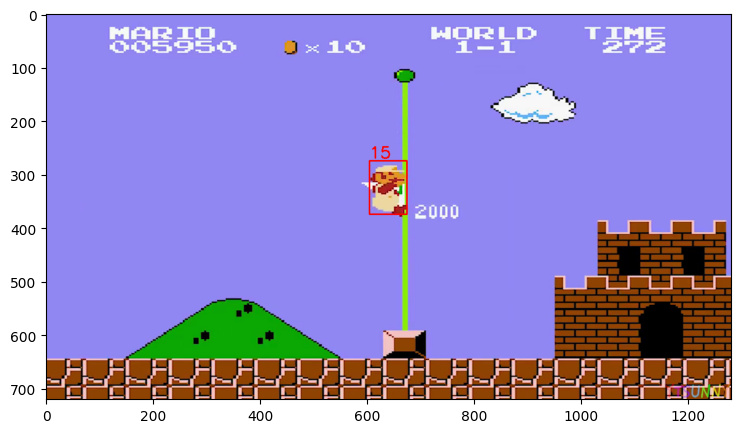

In [106]:
from tracking import draw_detections

fig = plt.figure(figsize=(9,5))
plt.imshow(draw_detections(frames[15], detections[15]))
plt.show()

Another way of visualization is to creating a video using all the frames using the <tt>draw_tracks</tt> function:

In [107]:
from skvideo import io as video_io
from tracking import draw_tracks

tracked_frames = draw_tracks(frames, detections, font_scale=0.6, thickness=2, frame_id_color=(0,0,0))

with video_io.FFmpegWriter("tracked_mario.mp4", outputdict={'-pix_fmt': 'yuv420p'}) as writer:
    for i in range(len(tracked_frames)):
        writer.writeFrame(tracked_frames[i])

display_video('tracked_mario.mp4', width=480, height=360)

**we can say that the algorithm ahs been implemented successfully,as mario is tracked (represented with an ellipse) throughout the whole video**

<font color='green'>**OPTIONAL TASK 1. Evaluation Metric**. The following code reads the groundtruth of a tracking video.

<font color='green'>&#9679;&ensp;Create a function that calculates the localization accuracy given by:</font>

<font color='green'>$$LocA = \frac{1}{n}\sum_{i=1}^{n}IoU(gt_i, det_i)$$

<font color='green'>where $n$ is the number of frames in the video, $IoU$ is a function that calculates the intersection over the union of two bounding boxes, $gt_i$ is the groundtruth bounding box at frame $i$, $det_i$ is the detected bounding box at frame $i$.

<font color='green'>&#9679;&ensp; Track Megaman from the megaman video and evaluate your results.</font>


In [108]:
# !pip install addict

In [109]:
from pathlib import Path
import xml.etree.ElementTree
from collections import namedtuple
from addict import Dict
from tracking import BoundingBox


def parse_track(cvat_xml: Path):
    tree = xml.etree.ElementTree.parse(cvat_xml)

    annotations_xml = tree.getroot()

    attributes = [('frame', int),
                  ('xtl', float),
                  ('ytl', float),
                  ('xbr', float),
                  ('ybr', float)]

    track = {}
    for track_xml in annotations_xml.iter('track'):
        for box_xml in track_xml.iter('box'):
            box = Dict({a: f(box_xml.get(a)) for a, f in attributes})
            track[box.frame] = BoundingBox([box.xtl, box.ytl, box.xbr, box.ybr])
    return track

track = parse_track('groundtruth/megaman.xml')

## **Part II. Multiple Object Tracking**

In this part, you will be introduced to basic techniques for creating a multiple object tracker (MOT).

### 1. Tracking Tennis Players


The task consists of tracking all the people in a *Tennis* game. Our inputs are the tennis video at <span style="color:red"><tt>'videos/tennis.mp4'</tt></span> and the bounding boxes of all detected people.

**Visualizing the video**. Let's display the video using Jupyter's API.


In [110]:
from utils import display_video

display_video('videos/tennis.mp4', width=480, height=360)

**Loading the video**. Let's load its frames.

In [111]:
from utils import read_video
from skimage import io

frames = read_video('videos/tennis.mp4')
num_frames = len(frames)

**Loading the semantic segmentation data**. We provide you with the semantic segmentation of all the people for all the frames. The semantic segmentation was extracted using a Deep Learning method named [PointRend](https://arxiv.org/abs/1912.08193). In the following cell we load the bounding boxes and masks for all the frames in the video that have a confidence score > 80%.

In [112]:
from utils import load_semantic_segmentation

bboxes, masks = load_semantic_segmentation('semantic_segmentation/tennis.npy', 0.8)

**Visualizing the semantic segmentation**. In the following cell we plot the bounding boxes of all segmented people for the first frame.

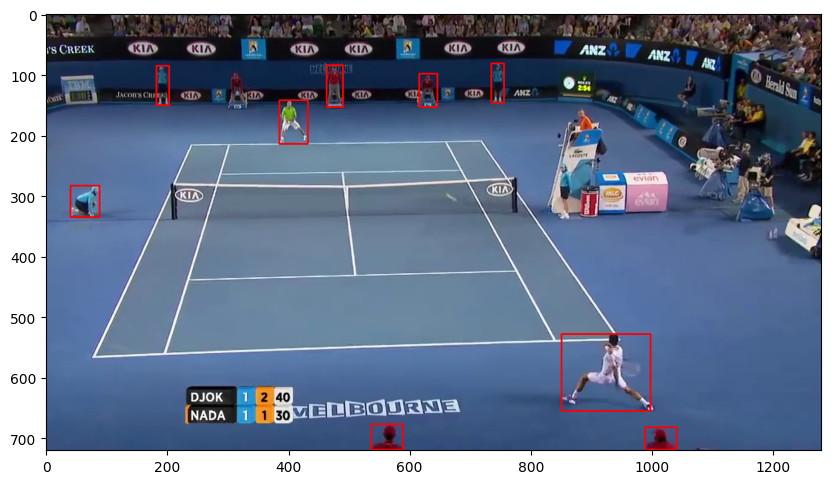

In [113]:
import matplotlib.pyplot as plt
from tracking import draw_boxes

frame_id = 0
fig = plt.figure(figsize=(10,6))
plt.imshow(draw_boxes(frames[frame_id], bboxes[frame_id], color=(255,0,0)))
plt.show()

Our first step for building a MOT tracker will be assigning an arbitrary ID to our bounding boxes in our *previous* frame. In this example, the ID of our previous frame should be $i=0$.

In [114]:
from tracking import DetectionBox

previous_frame_id = 0
previous_frame = frames[previous_frame_id]
previous_detections = []

for id_, bb in enumerate(bboxes[previous_frame_id]):
    previous_detections.append(DetectionBox(id_, bb))

**Visualizing the frames to match**. In the following tasks, we will assume that our **next frame is $i=40$**. The next cell shows the detected bounding boxes with their corresponding ID for the first frame and the next frame with its red bounding boxes.

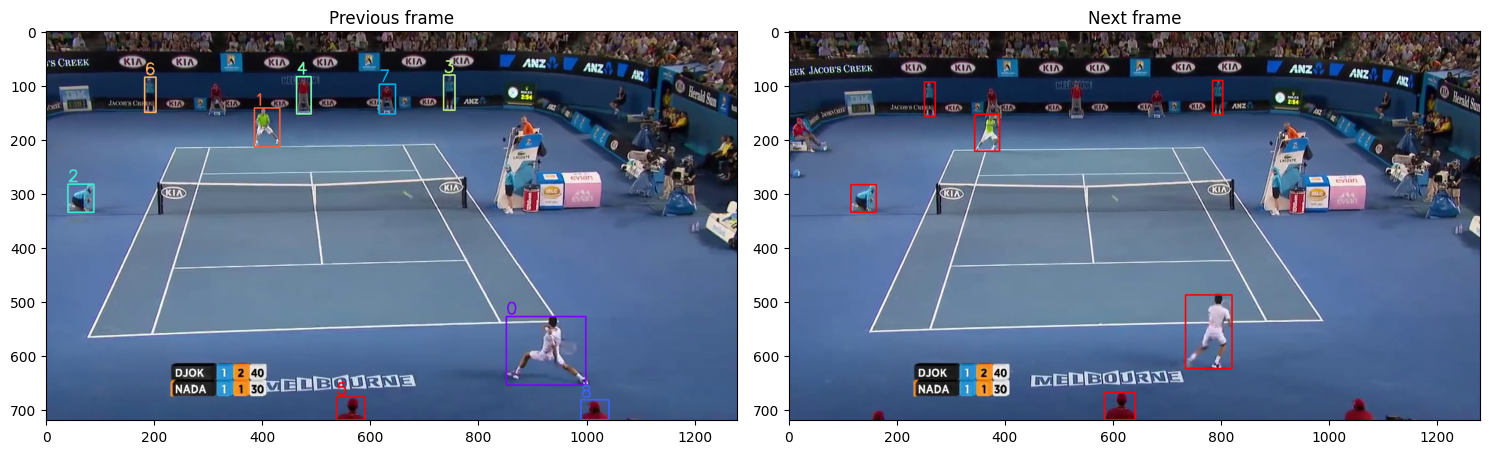

In [115]:
import matplotlib.pyplot as plt
from tracking import draw_detections

next_frame_id = 40
next_frame = frames[next_frame_id]
next_bboxes = bboxes[next_frame_id]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
ax1.set_title("Previous frame")
ax1.imshow(draw_detections(previous_frame, previous_detections))
ax2.set_title("Next frame")
ax2.imshow(draw_boxes(next_frame, next_bboxes))
fig.tight_layout()
plt.show()


The second step for creating our MOT tracker is creating a similarity matrix that tells us how similar are all the detected objects in the *next frame* w.r.t. to each detected object in the *previous frame*.

<font color='green'>**T8. Similarity matrix**. A simple similarity matrix will only take into account the distance between bounding boxes. Complete the ``calculate_distance_matrix`` function in the following cell. The input of this function are the detected bounding boxes from the previous frame and the bounding boxes from the next frame. Each element in the matrix is the Euclidean distance in pixels between the centroids of the bounding boxes.

The necessary elements of the function then :

Parameters:
- prev_bboxes: List of bounding boxes from the previous frame.
- next_bboxes: List of bounding boxes from the next frame.

Returns:
- distances: NumPy array (shape: (len(prev_bboxes), len(next_bboxes))) where each element (i, j) is the Euclidean distance between prev_bboxes[i] and next_bboxes[j].

In [116]:
from itertools import product
from numpy import linalg as LA
import numpy as np

def calculate_distance_matrix(prev_bboxes, next_bboxes):

    prev_centroids = [bb.centroid() for bb in prev_bboxes]
    next_centroids = [bb.centroid() for bb in next_bboxes]

    ######################### COMPLETE THIS FUNCTION ##########################
    distances = np.zeros((len(prev_centroids), len(next_centroids)))

    for i, j in product(range(len(prev_centroids)), range(len(next_centroids))):

        distances[i, j] = LA.norm(np.array(prev_centroids[i]) - np.array(next_centroids[j])) # euclidean distance
    ###########################################################################

    return distances



In [117]:
distance_matrix= calculate_distance_matrix(previous_detections, next_bboxes)

<font color='green'>**T9. Similarity matrix**. In the next cell, the values of the non-square distance matrix are plot.

<font color='green'>&#9679;&ensp;What does it mean that an element of the matrix has a small value?
    
<font color='green'>&#9679;&ensp;What does it mean that an element of the matrix has a large value?

<font color='green'>&#9679;&ensp;State the possible causes of having less bounding boxes in the next frame.

<font color='green'>&#9679;&ensp;How does it affects the multiple-object tracking?

**•  It means that element(i,j) of the distance matrix of the bounding box 'i' in the previous frame and the bounding box 'j' of the next frame are relatively close in relation with euclidean distance between centroid.Suggests a higher probability that the bounding boxes are from the same object that slightly move between frames.**


**• The bounding box 'i' in the previous frame and the bounding box 'j' in the next frame are far from each other. So it means the bounding boxes don't match the same object, could be different object or the same object moved in a big distance.**

**• Possible causes of having less bounding boxes:**


**- Oclussion: An object can be completely occluted or partially.**
**- Leave the scene: Object not present in camara vision.**

**- Fails in detection: The detector might not found the object in the next frame due to noise, sensibility to illumination , pose changes, occlusion or other factor that affects the appeareance .**


**- Object fusion: Two objects or more can be very close and detected as only one.**


**• We would say it affects of multiple object tracking (MOT)**


**- Losing identity: If an object disappears the tracker can assign another identity when it reappears or remove the trajectory.**


**- Fake negative: The missing detection of an object might induce to a fake negative, that affects the tracker.**


**-Fragmentation: occlusion might affect in object trajectory, causes it fragmentates in multiples trajectories insted of only one.**



<font color='green'> **OPTIONAL TASK 2**. Think of a better similarity metric that we covered in theory. Implement in the code below, instead of Euclidian distance. </font>

In [118]:
######################### COMPLETE THIS FUNCTION ##########################



###########################################################################

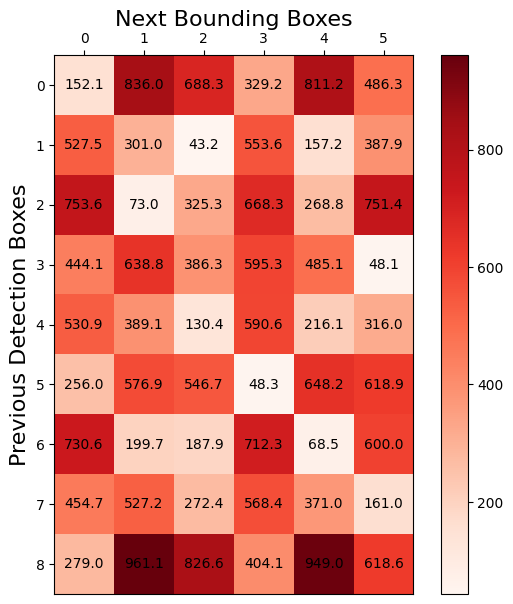

In [119]:
from utils import plot_similarity_matrix

plot_similarity_matrix(distance_matrix, figsize=(7,7))

The last step of our MOT is to match the previous detections with the predictions in the next frame.

<font color='green'>**T10. Matching bounding boxes and IDs assignation**. Complete the ``calculate_matches`` function in the following cell using the Hungarian algorithm.

You can use a library to call Hungarian algorithm. Please check online on to consult how to use it.

In [120]:
# !pip install munkres

In [121]:
from munkres import Munkres, print_matrix
import numpy as np
from itertools import product

def calculate_matches(similarity_matrix):
    matches = []

    m = Munkres()

    # Pad the similarity matrix to make it square
    rows, cols = similarity_matrix.shape
    size = max(rows, cols)

    padded_matrix = np.zeros((size, size))
    padded_matrix[:rows, :cols] = similarity_matrix


    # Compute the optimal assignments
    indexes = m.compute(padded_matrix)

    matches = [(row, col) for row, col in indexes if row < rows and col < cols]

    return matches


matches = calculate_matches(distance_matrix)

# ID ASSIGNATION
next_detections = []
for (i,j) in matches:
    prev_detection_id = previous_detections[i].id_
    next_bbox = next_bboxes[j]

    next_detection = DetectionBox(prev_detection_id, next_bbox)
    next_detections.append(next_detection)

**Visualizing the matches**. The following cell shows the matched boxes for both frames.

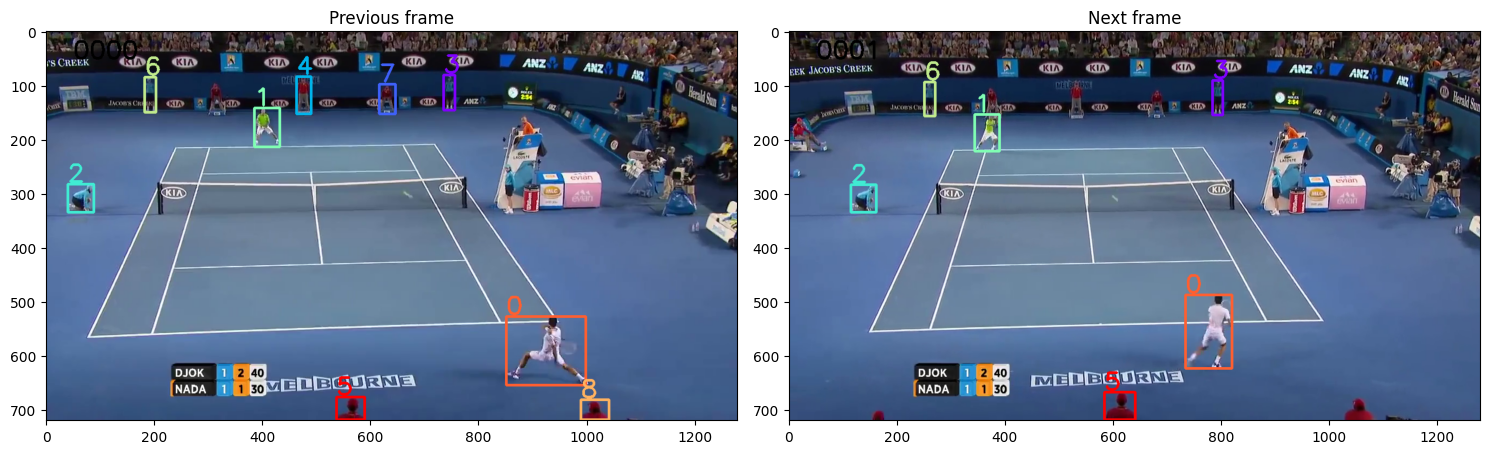

In [122]:
from tracking import draw_tracks

tracked_frames = draw_tracks([previous_frame, next_frame], {0: previous_detections, 1: next_detections}, font_scale=1.5, thickness=3, frame_id_color=(0,0,0))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
ax1.set_title("Previous frame")
ax1.imshow(tracked_frames[0])
ax2.set_title("Next frame")
ax2.imshow(tracked_frames[1])
fig.tight_layout()
plt.show()

**Some matches weren't displayed, for cases 4 , 7 and 8, initially in the function (draw_detections) were not detected in the next frame, so it's due to this given function in the code. Whereas for the other detections were correctly found and displayed.**

<font color='green'>**T11. Build a distance MOT tracker**. The following code forms the skeleton of a distance MOT tracker. Use the ``calculate_distance_matrix`` and ``calculate_matches`` functions to complete the ``track_multiple_object`` function. After visualizing the track, evaluate your results. </font>

Our function has to correctly track multiple objects across frames by matching bounding boxes from consecutive frames using centroid distance and the Hungarian algorithm (Munkres method). Before using ***calculate_distance_matrix*** and ***calculate_matches*** , we get the centroids of the previous and current bboxes using BoundingBox for each frame_idx . Once we get the matches we just append them to the detections list and finally we get our tracking function.

In [123]:
import numpy as np
from itertools import product
from tracking import BoundingBox, DetectionBox


def track_multiple_objects(bboxes):

    num_frames = len(bboxes)
    # Initializing the detections data structure
    detections = {frame_idx: [] for frame_idx in range(num_frames)}

    # Assigning arbitrary IDs to the bounding boxes of the first frame
    frame_idx = 0
    for i, bb in enumerate(bboxes[frame_idx]):
        detections[frame_idx].append(DetectionBox(i, bb))

    ######################### COMPLETE THIS FUNCTION ##########################


    for frame_idx in range(1, num_frames):
        #  Bounding boxes of current
        current_bboxes = bboxes[frame_idx]
        previous_detections = detections[frame_idx - 1]

        # Create BoundingBox instances for centroid
        previous_bboxes = [BoundingBox(d.bbox) for d in previous_detections]
        c_bboxes = [BoundingBox(bb.bbox) for bb in current_bboxes]

        #calculates distance matrix
        distance_matrix = calculate_distance_matrix(previous_bboxes, current_bboxes)
        matches = calculate_matches(distance_matrix)

        # Updates detections from the matches
        for (i, j) in matches:
           prev_detection_id = previous_detections[i].id_
           current_bboxes_id = c_bboxes[j]
           detection = DetectionBox(prev_detection_id, current_bboxes_id)
           detections[frame_idx].append(detection)

   ####################################################################################

    return detections


detections = track_multiple_objects(bboxes)

**Visualizing the tracking results**. You can visualize your tracking results in a single frame using the <tt>draw_detections</tt> function as follows:

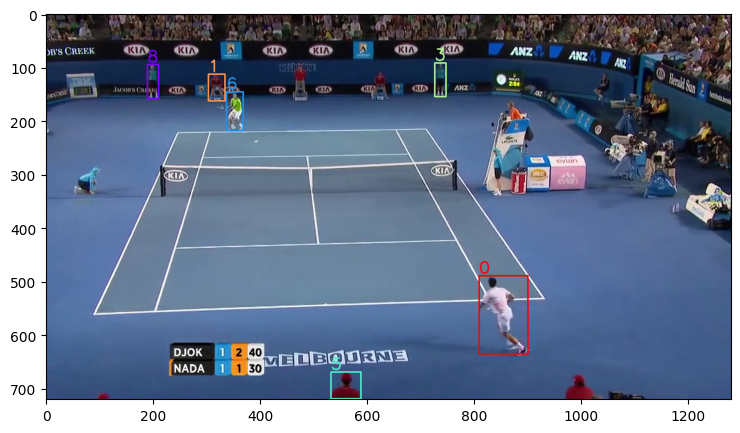

In [124]:
from tracking import draw_detections

fig = plt.figure(figsize=(9,5))
plt.imshow(draw_detections(frames[15], detections[15]))
plt.show()

Another way of visualization is to creating a video using all the frames using the <tt>draw_tracks</tt> function:

In [125]:
from skvideo import io as video_io
from tracking import draw_tracks

tracked_frames = draw_tracks(frames, detections, font_scale=0.6, thickness=2, frame_id_color=(0,0,0))

with video_io.FFmpegWriter("tracked_tennis.mp4", outputdict={'-pix_fmt': 'yuv420p'}) as writer:
    for i in range(len(tracked_frames)):
        writer.writeFrame(tracked_frames[i])

display_video('tracked_tennis.mp4', width=480, height=360)